In [16]:
import os
from glob import glob
from PIL import Image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
import pandas as pd
import numpy as np

In [2]:
dataset_dir = r"C:\\Users\\honey\\Documents\\Data Science\\Course and Internships\\LetsGrowMore\\Task No.9 Math Equation Solver\\extracted_images"

In [3]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize pixel values and set a validation split

# Train generator
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),  # Resize images as required
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Training data

# Validation generator
validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Validation dat

Found 300813 images belonging to 82 classes.
Found 75161 images belonging to 82 classes.


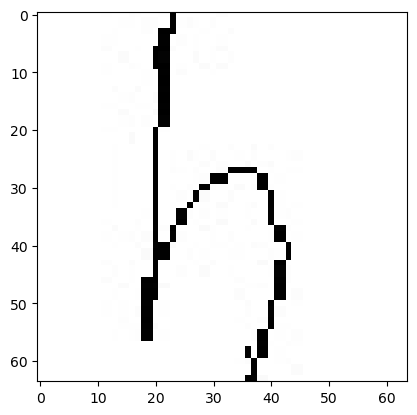

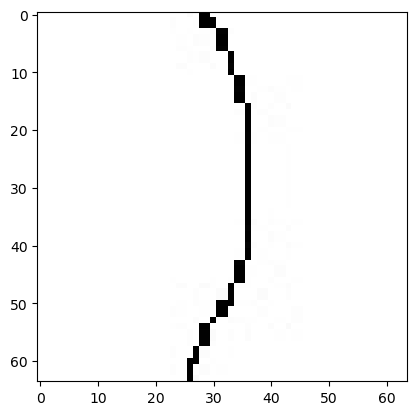

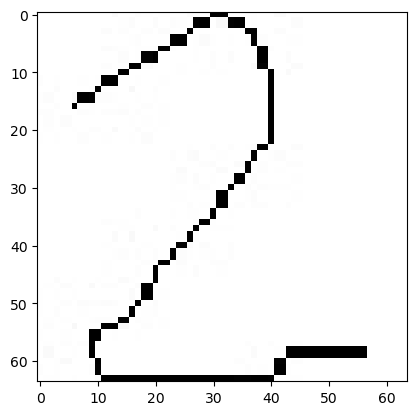

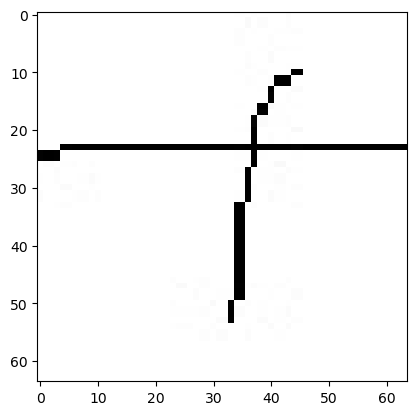

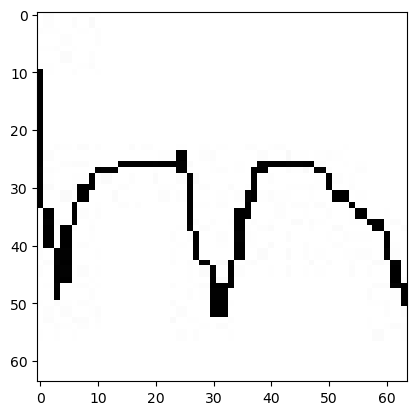

In [4]:
# Visualize some images from the dataset
x_batch, y_batch = next(train_generator)
for i in range(5):
    plt.imshow(x_batch[i])
    plt.show()

In [12]:
import os
import shutil
import random

# Set the path to the main dataset directory
dataset_dir = r"C:\\Users\\honey\\Documents\\Data Science\\Course and Internships\\LetsGrowMore\\Task No.9 Math Equation Solver\\extracted_images"  # Replace with your dataset path

# Set the output directory for the balanced dataset
output_dir = r"C:\\Users\\honey\\Documents\\Data Science\\Course and Internships\\LetsGrowMore\\Task No.9 Math Equation Solver\\Bias_reduced_images" 

# Number of images to retain per folder
max_images_per_folder = 4000

# Iterate over each folder in the dataset directory
for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)
    
    if os.path.isdir(folder_path):
        # List all image files in the current folder
        images = os.listdir(folder_path)
        
        # Shuffle the images to ensure random selection
        random.shuffle(images)
        
        # Limit the number of images to the specified max_images_per_folder
        images_to_keep = images[:max_images_per_folder]
        
        # Create the corresponding folder in the output directory
        new_folder_path = os.path.join(output_dir, folder_name)
        os.makedirs(new_folder_path, exist_ok=True)
        
        # Copy the selected images to the new folder
        for image_name in images_to_keep:
            src_path = os.path.join(folder_path, image_name)
            dest_path = os.path.join(new_folder_path, image_name)
            shutil.copy(src_path, dest_path)
        
        print(f"Processed folder: {folder_name} - kept {len(images_to_keep)} images.")

print("Dataset reduction complete.")

Processed folder: ! - kept 1300 images.
Processed folder: ( - kept 4000 images.
Processed folder: ) - kept 4000 images.
Processed folder: + - kept 4000 images.
Processed folder: , - kept 1906 images.
Processed folder: - - kept 4000 images.
Processed folder: 0 - kept 4000 images.
Processed folder: 1 - kept 4000 images.
Processed folder: 2 - kept 4000 images.
Processed folder: 3 - kept 4000 images.
Processed folder: 4 - kept 4000 images.
Processed folder: 5 - kept 3545 images.
Processed folder: 6 - kept 3118 images.
Processed folder: 7 - kept 2909 images.
Processed folder: 8 - kept 3068 images.
Processed folder: 9 - kept 3737 images.
Processed folder: = - kept 4000 images.
Processed folder: A - kept 4000 images.
Processed folder: alpha - kept 2546 images.
Processed folder: ascii_124 - kept 1339 images.
Processed folder: b - kept 4000 images.
Processed folder: beta - kept 2025 images.
Processed folder: C - kept 4000 images.
Processed folder: cos - kept 2986 images.
Processed folder: d - k

In [17]:
# Path to the balanced dataset directory
csv_file = 'extracted_features.csv'  # Output CSV file

# Labels for symbols (assuming 0-9 digits and symbols '+', '-', 'times')
label_mapping = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'minus': 10, 'plus': 11, 'times': 12
}

# Function to extract features from an image
def extract_features(image_path, label):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Invert the image (make background black and digit white)
    inverted_img = cv2.bitwise_not(img)
    
    # Convert to binary image
    _, binary_img = cv2.threshold(inverted_img, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the contour with maximum bounding rectangle area
    max_area = 0
    best_rect = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area > max_area:
            max_area = area
            best_rect = (x, y, w, h)
    
    if best_rect:
        x, y, w, h = best_rect
        # Crop the bounding rectangle
        cropped_img = binary_img[y:y+h, x:x+w]
        
        # Resize to 28x28 pixels
        resized_img = cv2.resize(cropped_img, (28, 28))
        
        # Flatten the image to a 784-dimensional vector
        features = resized_img.flatten()
        
        # Add label to the feature vector
        labeled_features = np.append(features, label)
        return labeled_features
    else:
        return None

# Prepare a list to hold feature vectors
data = []

# Iterate over each folder in the output_dir
for folder_name in os.listdir(output_dir):
    folder_path = os.path.join(output_dir, folder_name)
    
    if folder_name in label_mapping:  # Only process folders that have a valid label
        label = label_mapping[folder_name]
        
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                
                # Extract features for each image
                features = extract_features(image_path, label)
                
                if features is not None:
                    data.append(features)
    
# Convert the data to a DataFrame and save as a CSV file
columns = [f'pixel_{i}' for i in range(784)] + ['label']
df = pd.DataFrame(data, columns=columns)
df.to_csv(csv_file, index=False)

print(f"Features extracted and saved to {csv_file}.")

Features extracted and saved to extracted_features.csv.
